Детектор аномалии на принципе многократной прогонки реконструкции входного образца до сходимости латентного вектора.
Критерий аномальности - расстояние от первоначального латентного вектора до сошедшего.

In [35]:
from dataclasses import dataclass
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import piqa
import sklearn.metrics as metrics
from sklearn.manifold import TSNE
from torchvision.transforms import v2
from torchinfo import summary
from matplotlib.colors import ListedColormap


In [36]:
batch_size = 256
learning_rate = 1e-2
num_epochs = 100
latent_dim = 21
mnist_class_anomaly = 4
kernels = 8
fuzzy_rules_count = 128

prefix = f"fuzzy_ad"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

binary_cmap = ListedColormap(['yellow', 'red'], N=2)
ssim = piqa.SSIM(window_size = 11, n_channels=1, reduction='none').to(device)
device

device(type='cuda')

## Датасет

1. Исключаем класс аномалии `mnist_class_anomaly` из общей выборк
2. Убираем метки с остальных классов
   

In [37]:
def norm_and_transform(x):
    nimg = x.view(-1, 28, 28)
    nimg = torch.clamp(nimg, 0, 1)
    return nimg

def clamp(x):
    #nimg = 2.0*(x.view(-1, 28, 28) - 0.5)
    nimg = torch.clamp(x, 0, 1)
    return nimg

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(norm_and_transform)
])

augmentation = transforms.Compose([
    transforms.RandomRotation(25, fill=0), 
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), fill=0), 
    #transforms.RandomCrop(size=26),
    #transforms.Resize(size=(28, 28)),
    transforms.Lambda(clamp)
])

In [38]:
def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_class_anomaly)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54158

загружаем тестовую выборку

In [39]:
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

Создаем итераторы датасетов

In [40]:

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

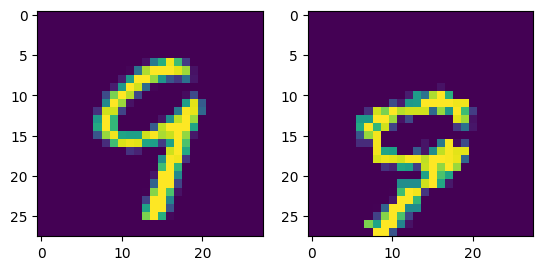

In [41]:
for data,_ in iter(train_loader):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.imshow(data[0].squeeze())
    plt.subplot(R, C, 2)
    plt.imshow(augmentation(data)[0].squeeze())
    
    
    break

## Модель

In [42]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim, kernels):
        super(Encoder, self).__init__()
                
        
        self.latent = nn.Sequential(
            nn.Conv2d(1, kernels, kernel_size = 5), 
            nn.Conv2d(kernels, kernels, kernel_size = 5), 
            nn.BatchNorm2d(kernels), 
            nn.SiLU(),

            nn.Conv2d(kernels, 2*kernels, kernel_size = 5), 
            nn.Conv2d(2*kernels, 2*kernels, kernel_size = 5), 
            nn.BatchNorm2d(2*kernels), 
            nn.SiLU(),

            nn.Conv2d(2*kernels, 4*kernels, kernel_size = 5), 
            nn.Conv2d(4*kernels, 4*kernels, kernel_size = 5), 
            nn.BatchNorm2d(4*kernels), 
            nn.SiLU(),

            nn.Conv2d(4*kernels, 8*kernels, kernel_size = 4), 
            nn.BatchNorm2d(8*kernels), 
            nn.SiLU(),
            
            nn.Flatten(),
            nn.Linear(8*kernels, 4*kernels), 
            nn.BatchNorm1d(4*kernels),
            nn.SiLU(),

            nn.Linear(4*kernels, 2*kernels), 
            nn.BatchNorm1d(2*kernels),
            nn.SiLU(),

            nn.Linear(2*kernels, latent_dim)
        )
        initial_centroids = (0.5-np.random.rand(fuzzy_rules_count, latent_dim))
        initial_scales =  2 * np.ones((fuzzy_rules_count, latent_dim))

        self.fuzzy_a = nn.Sequential(
            FuzzyLayer.from_centers_and_scales(initial_centroids, initial_scales)
        )

    def forward(self, x):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """
        latent = self.latent(x)
        #pt_a, pt_b = torch.chunk(latent, 2, dim=-1)
        fz = self.fuzzy_a(latent)
        #fz = (fz.clamp(min=0.1) - 0.1)/0.9
        #fz_b = self.fuzzy_b(pt_b)
        #fz = torch.cat((fz_a, fz_b),1)
        return fz, latent

inp = torch.rand(10, 1, 28, 28)
m = Encoder(latent_dim, 16)
fz, mu = m.forward(inp)

summary(m, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [256, 128]                --
├─Sequential: 1-1                        [256, 21]                 --
│    └─Conv2d: 2-1                       [256, 16, 24, 24]         416
│    └─Conv2d: 2-2                       [256, 16, 20, 20]         6,416
│    └─BatchNorm2d: 2-3                  [256, 16, 20, 20]         32
│    └─SiLU: 2-4                         [256, 16, 20, 20]         --
│    └─Conv2d: 2-5                       [256, 32, 16, 16]         12,832
│    └─Conv2d: 2-6                       [256, 32, 12, 12]         25,632
│    └─BatchNorm2d: 2-7                  [256, 32, 12, 12]         64
│    └─SiLU: 2-8                         [256, 32, 12, 12]         --
│    └─Conv2d: 2-9                       [256, 64, 8, 8]           51,264
│    └─Conv2d: 2-10                      [256, 64, 4, 4]           102,464
│    └─BatchNorm2d: 2-11                 [256, 64, 4, 4]        

In [43]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, fuzzy_rules_count, kernels):
        super(Decoder, self).__init__()

        self.defuzzy = nn.Sequential(
            DefuzzyLinearLayer.from_dimensions(fuzzy_rules_count, 28*28, with_norm=False),
            nn.Sigmoid())
        
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """
        out = self.defuzzy(z)
        #out = out.clamp(0, 1)
        out = out.reshape(-1, 1, 28, 28)
        return out
    
inp = torch.rand(batch_size, fuzzy_rules_count)
m = Decoder(fuzzy_rules_count, 16)
mu = m.forward(inp)
mu.shape

summary(m, input_size=(batch_size, fuzzy_rules_count))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [256, 1, 28, 28]          --
├─Sequential: 1-1                        [256, 784]                --
│    └─DefuzzyLinearLayer: 2-1           [256, 784]                100,352
│    └─Sigmoid: 2-2                      [256, 784]                --
Total params: 100,352
Trainable params: 100,352
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.13
Forward/backward pass size (MB): 1.61
Params size (MB): 0.40
Estimated Total Size (MB): 2.14

In [44]:
class VAE(nn.Module):
    """
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, fuzzy_rules_count, kernels):
        super(VAE, self).__init__()

        self.encoder = Encoder(latent_dim, kernels)        
        self.decoder = Decoder(fuzzy_rules_count, kernels)
        

    def forward(self, x):
        """
        
        """
        fz, mu = self.encoder(x)
        x_recon = self.decoder(fz)
        
        return fz, mu, x_recon
    
    def half_pass(self, x):
        """
        
        """
        fz, mu = self.encoder(x)
        return fz, mu
    
    def decoder_pass(self, x):
        r = self.decoder(x)
        return r

## Обучение

In [45]:
model = VAE(latent_dim=latent_dim, fuzzy_rules_count=fuzzy_rules_count, kernels=kernels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

summary(model, input_size=(batch_size, 1, 28, 28))

Number of parameters: 218,653


Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [256, 128]                --
├─Encoder: 1-1                           [256, 128]                --
│    └─Sequential: 2-1                   [256, 21]                 --
│    │    └─Conv2d: 3-1                  [256, 8, 24, 24]          208
│    │    └─Conv2d: 3-2                  [256, 8, 20, 20]          1,608
│    │    └─BatchNorm2d: 3-3             [256, 8, 20, 20]          16
│    │    └─SiLU: 3-4                    [256, 8, 20, 20]          --
│    │    └─Conv2d: 3-5                  [256, 16, 16, 16]         3,216
│    │    └─Conv2d: 3-6                  [256, 16, 12, 12]         6,416
│    │    └─BatchNorm2d: 3-7             [256, 16, 12, 12]         32
│    │    └─SiLU: 3-8                    [256, 16, 12, 12]         --
│    │    └─Conv2d: 3-9                  [256, 32, 8, 8]           12,832
│    │    └─Conv2d: 3-10                 [256, 32, 4, 4]           25,6

In [46]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=len(train_loader))
#sched = torch.optim.lr_scheduler.ConstantLR(optimizer, learning_rate)

In [47]:
def compute_ae_loss(x, recon_x):
    #loss_c = ssim(x, centroid).clamp(0, 1).detach()
    loss_recon = (1 - ssim(recon_x, x))#(x-recon_x).square()#
    loss_recon = loss_recon.mean()
    return loss_recon
    

In [48]:
def compute_fuzzy_loss(fz):

    return (1 - fz.sum(-1)).square().mean() #(0.999 - (tops[:,0]+tops[:,1]).clamp(max=0.999)).mean() + tops[:, 2].clamp(min=0.001).mean()

In [49]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [50]:
def fuzzy_term_volume_loss(layer, fz):
    dfz = fz.detach().mean(0)
    
    ev = layer.get_transformation_matrix_eigenvals().real.mean(-1)
    ev = 1/ev.mean()
    
    return ev#(1 - fz.max(-1).values).abs().mean()#

In [51]:
def get_arate(inp):
    fz, mu, x_recon = model.forward(inp)
    
    return fz.sum(-1).cpu().numpy() #(1 - ssim(x_recon.clamp(0, 1), inp)).cpu().numpy()#xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def train(model, dataloader, optimizer, sched, prev_updates, epoch, writer=None):
    model.train()  
    
    for batch_idx, (data, _) in enumerate(tqdm(dataloader, disable=True)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        adata = augmentation(data)
        
        optimizer.zero_grad()  
        
        fz, mu = model.half_pass(adata)  
        x_reconstruct = model.decoder_pass(fz)
        #x_centroidal = model.decoder(F.one_hot(fz.argmax(-1), fuzzy_rules_count).float())
        
        loss_reconstruct = compute_ae_loss(data, x_reconstruct)
        
        #fz_loss = fuzzy_term_volume_loss(model.encoder.fuzzy_a[0], fz)
        
        ev_loss = keep_eigenvals_positive_loss(model.encoder.fuzzy_a[0])
        if ev_loss.item() > 0:
            ev_loss.backward(retain_graph=True)
        #ev_loss = keep_eigenvals_positive_loss(model.encoder.fuzzy_b[0])
        #if ev_loss.item() > 0:
        #    ev_loss.backward(retain_graph=True)
        #(2 - fz.sum(-1)).mean().square().backward(retain_graph=True)
        loss_reconstruct.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-3)
        optimizer.step()  
        
        if sched is not None:
            sched.step()
        
    if writer is not None:
        writer.add_scalar('FAD/LR', get_lr(optimizer), global_step=epoch)
        
    return prev_updates + len(dataloader)

In [53]:
#fixed_random_z = torch.randn(16, fuzzy_rules_count).to(device)

def test(model, dataloader, cur_step, epoch, writer=None):
    model.eval() 

    test_recon_loss = 0
    test_fz_loss = 0
    test_fz_sum_loss = 0
    
    lab_true = []
    lab_pred = []

    with torch.no_grad():
        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = get_arate(data)
            
            for f, l in  zip(rates, lab):
                lab_pred.append(f)        
                if l == mnist_class_anomaly:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
    fpr, tpr, _ = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    embedings = []
    labels_expected = []
    
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing', disable=True):
            data = data.to(device)

            fz, mu = model.half_pass(data)  
            x_reconstruct = model.decoder_pass(fz)
            #x_centroidal = model.decoder(F.one_hot(fz.argmax(-1), fuzzy_rules_count).float())

            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())

            loss_recon = compute_ae_loss(data, x_reconstruct)
            fz_loss = fuzzy_term_volume_loss(model.encoder.fuzzy_a[0], fz)
            
            test_recon_loss += loss_recon.item()
            test_fz_loss += fz_loss.item()
            test_fz_sum_loss += fz.sum(-1).mean()
            

    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)
   
    test_recon_loss /= len(dataloader)
    test_fz_loss /= len(dataloader)
    test_fz_sum_loss /= len(dataloader)
    
    print(f'[{cur_step}] Reconstruction loss: {test_recon_loss:.4f}, VOL: {test_fz_loss:.4f} SUM: {test_fz_sum_loss:.2f} AUC: {roc_auc:.4f}')
    #print(f'Average activation stats: {model.decoder.fuzzy[2].get_norm_stats()}')
    #print(f'Average centroid stats: {model.decoder.fuzzy[0].get_average_centroid()}')
    if writer is not None:
        writer.add_scalar('FAD/AUC', roc_auc, global_step=cur_step)
        writer.add_scalar('FAD/Reconstruction', test_recon_loss, global_step=cur_step)
        writer.add_scalar('FAD/Fz', test_fz_loss, global_step=cur_step)
        writer.add_scalar('FAD/Sum', test_fz_sum_loss, global_step=cur_step)
        
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        centroids_a = model.encoder.fuzzy_a[0].get_centroids().detach().cpu().numpy()
        #centroids_b = model.encoder.fuzzy_b[0].get_centroids().detach().cpu().numpy()
        ax[0].scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
        ax[0].scatter(centroids_a[:, 0],      centroids_a[:, 1], marker='1', c='black', s= 50)
        #ax[0].scatter(centroids_b[:, 0],      centroids_b[:, 1], marker='2', c='black', s= 50)
        
        ax[1].scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
        ax[1].scatter(centroids_a[:, 1],      centroids_a[:, 2], marker='1', c='black', s= 50)
        #ax[1].scatter(centroids_b[:, 1],      centroids_b[:, 2], marker='2', c='black', s= 50)
    
        act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
        samples = model.decoder(act_fz)
        img_idx = 0
        fign, axn = plt.subplots(8, 1 + fuzzy_rules_count//8, figsize=(1 + fuzzy_rules_count//8, 8), squeeze=False)
        for i in range(8):
            if img_idx >= fuzzy_rules_count:
                continue
            for j in range(fuzzy_rules_count//8):
                axn[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
                axn[i, j].axis('off')
                img_idx += 1

        writer.add_figure('FAD/Emedding', fig, global_step=cur_step)
        writer.add_figure('FAD/Samples', fign, global_step=cur_step)

In [54]:
prev_updates = 0

In [55]:
for epoch in range(num_epochs):
    prev_updates = train(model, train_loader, optimizer, sched, prev_updates, epoch, writer=writer)
    test(model, test_loader, prev_updates, epoch, writer=writer)
    #scheduler.step()

[212] Reconstruction loss: 0.9841, VOL: 0.4970 SUM: 2.06 AUC: 0.5714
[424] Reconstruction loss: 0.9678, VOL: 0.4970 SUM: 2.16 AUC: 0.5958
[636] Reconstruction loss: 0.9451, VOL: 0.4971 SUM: 2.26 AUC: 0.6078
[848] Reconstruction loss: 0.9127, VOL: 0.4971 SUM: 2.18 AUC: 0.6093
[1060] Reconstruction loss: 0.8771, VOL: 0.4970 SUM: 2.32 AUC: 0.6811
[1272] Reconstruction loss: 0.8584, VOL: 0.4969 SUM: 2.06 AUC: 0.6223
[1484] Reconstruction loss: 0.8366, VOL: 0.4970 SUM: 2.14 AUC: 0.6071
[1696] Reconstruction loss: 0.8166, VOL: 0.4970 SUM: 2.29 AUC: 0.6863
[1908] Reconstruction loss: 0.8039, VOL: 0.4970 SUM: 1.97 AUC: 0.6204
[2120] Reconstruction loss: 0.7633, VOL: 0.4970 SUM: 2.16 AUC: 0.6699
[2332] Reconstruction loss: 0.6839, VOL: 0.4967 SUM: 2.09 AUC: 0.4857
[2544] Reconstruction loss: 0.6487, VOL: 0.4963 SUM: 1.88 AUC: 0.5809
[2756] Reconstruction loss: 0.6136, VOL: 0.4955 SUM: 2.02 AUC: 0.4839
[2968] Reconstruction loss: 0.6227, VOL: 0.4950 SUM: 2.11 AUC: 0.5009
[3180] Reconstruction lo

KeyboardInterrupt: 

In [56]:
keep_eigenvals_positive_loss(model.encoder.fuzzy_a[0])

tensor(-1.0000e-15, device='cuda:0', grad_fn=<NegBackward0>)

## Визуализируем результаты

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<BarContainer object of 60 artists>

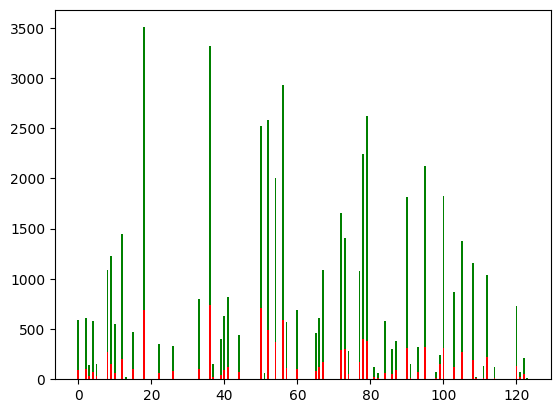

In [57]:

def get_activation_stats(model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, _) in enumerate(tqdm(dataloader)):
            data = data.to(device)
            fz, mu, rec_x = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind in act_fz:
                rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat

train_stat = get_activation_stats(model, train_loader)
test_stat = get_activation_stats(model, test_loader)

plt.bar(list(train_stat.keys()), train_stat.values(), 0.5, color='g')
plt.bar(list(test_stat.keys()), test_stat.values(), 0.5, color='r')

  0%|          | 0/40 [00:00<?, ?it/s]

(-1.0, 129.0)

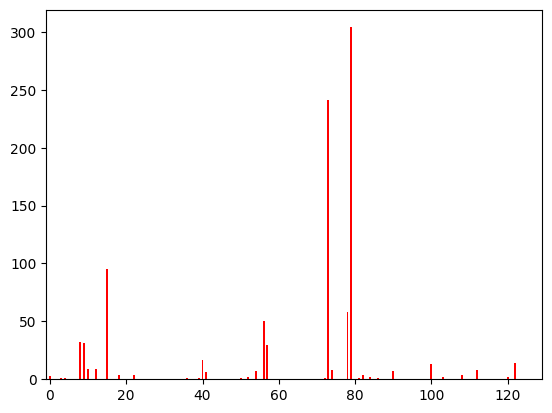

In [58]:

def get_activation_stats_by_digit(digit, model, dataloader):
    rulestat = {}
    with torch.no_grad():
        for _, (data, target) in enumerate(tqdm(dataloader)):
        
            data = data.to(device)
            fz, mu, rec_x = model.forward(data)
            act_fz = fz.max(-1).indices.cpu().numpy()
            for ind, trg in zip(act_fz, target):
                if trg == digit:
                    rulestat[ind] = rulestat.get(ind, 0) + 1
    return rulestat


test_stat_by_digit = get_activation_stats_by_digit(8, model, test_loader)

plt.bar(list(test_stat_by_digit.keys()), test_stat_by_digit.values(), 0.5, color='r')
plt.xlim((-1, fuzzy_rules_count + 1))

In [59]:
test_stat_by_digit

{79: 304,
 73: 241,
 9: 31,
 15: 95,
 78: 58,
 40: 17,
 100: 13,
 56: 50,
 12: 9,
 10: 9,
 54: 7,
 8: 32,
 57: 30,
 108: 4,
 74: 8,
 3: 1,
 82: 4,
 112: 8,
 72: 1,
 120: 2,
 90: 7,
 122: 14,
 103: 2,
 86: 1,
 41: 6,
 22: 4,
 84: 2,
 0: 3,
 39: 1,
 4: 1,
 50: 1,
 18: 4,
 52: 2,
 36: 1,
 81: 1}

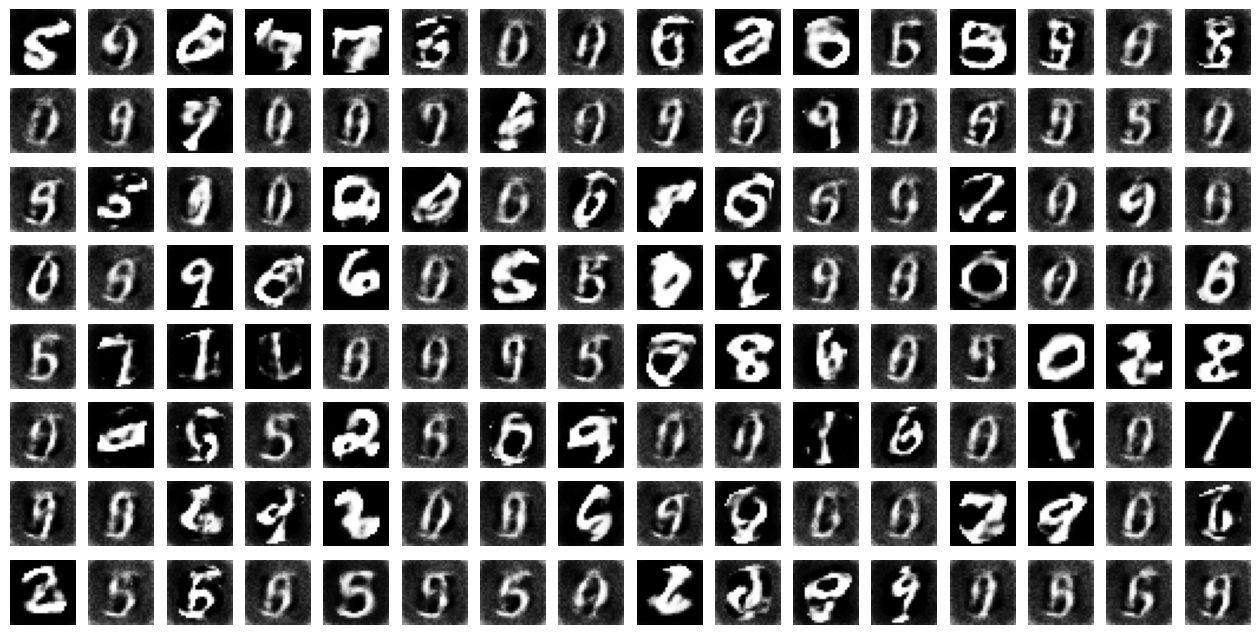

In [60]:
with torch.no_grad():
    act_fz = torch.diag(torch.ones(fuzzy_rules_count)).to(device)
    samples = model.decoder(act_fz)
    img_idx = 0
    fig, ax = plt.subplots(8, fuzzy_rules_count//8, figsize=(fuzzy_rules_count//8, 8))
    for i in range(8):
        for j in range(fuzzy_rules_count//8):
            ax[i, j].imshow(samples[img_idx].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')
            img_idx += 1

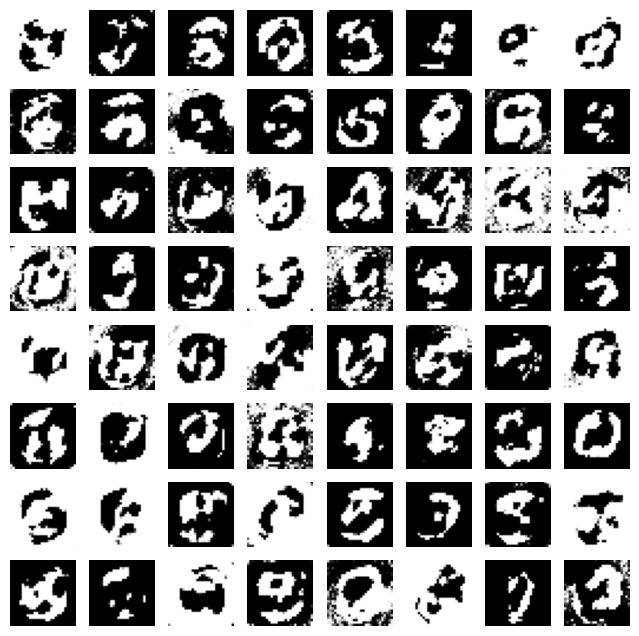

In [61]:
with torch.no_grad():
    z = torch.randn(64, fuzzy_rules_count).to(device)
    samples = model.decoder_pass(z)

    # Plot the generated images
    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[i, j].axis('off')


In [62]:
def get_arate(inp):
    fz, mu, x_recon = model.forward(inp)
    return (1 - ssim(x_recon, inp)).cpu().numpy()#fz.sum(-1).cpu().numpy() #xent_continuous_ber((x_recon + 1)/2, (inp + 1)/2).cpu().numpy()# #ssim((inp + 1)/2, (recon_x+1)/2).cpu().numpy() #fz.sum(-1).cpu().numpy()#(inp - x_recon).abs().sum(-1).sum(-1).mean(-1).cpu().numpy()#

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

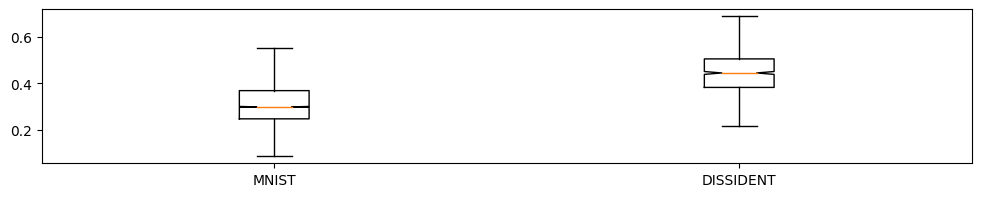

In [63]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_class_anomaly:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

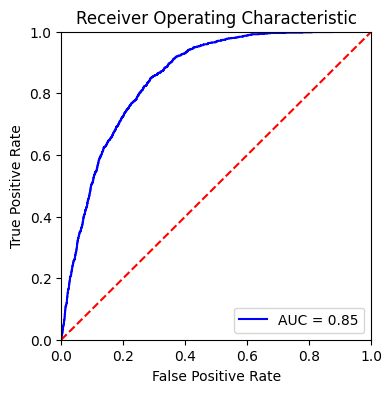

In [64]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_class_anomaly:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = threshold[optimal_idx]
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

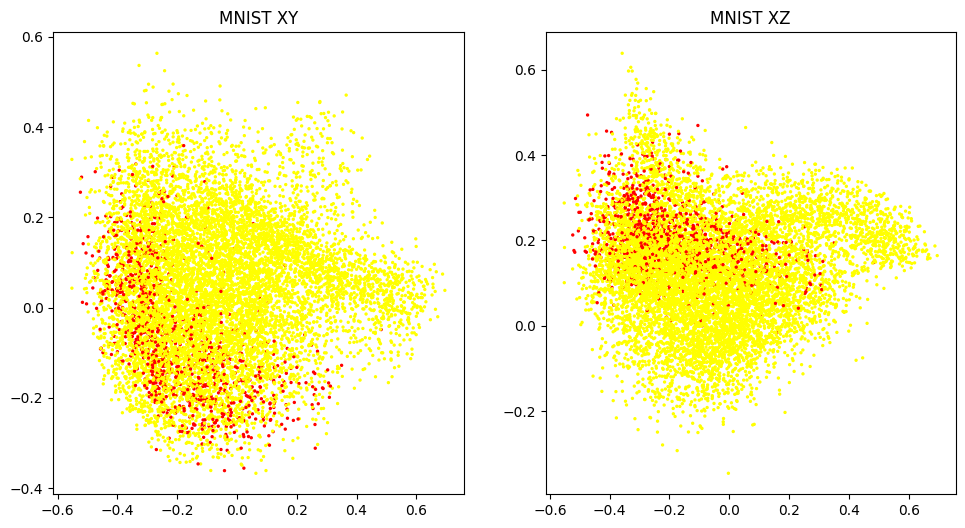

In [65]:


def show_plot():
    #centroids = model.encoder.fuzzy[0].get_centroids().detach().cpu().numpy()
    embedings = []
    labels_expected = []
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Encoding'):
            data = data.view((-1,1,28,28)).to(device)
            fz, mu, rec_x = model.forward(data)
            embedings.append(mu.cpu().numpy())
            labels_expected.append((target == mnist_class_anomaly).cpu().numpy())
    embedings = np.concatenate(embedings, axis=0)
    labels_expected = np.concatenate(labels_expected, axis=0)

    plt.figure(figsize=(18, 6))

    R, C = 1, 3

    plt.subplot(R, C, 1)
    plt.title("MNIST XY")
    
    plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 1], marker='1', c='black', s= 50)

    plt.subplot(R, C, 2)
    plt.title("MNIST XZ")
    plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap=binary_cmap, s=2)
    #plt.scatter(centroids[:, 0],      centroids[:, 2], marker='1', c='black', s= 50)

    
show_plot()

In [66]:
def show_item_reconstructio(ind):
    for data, trg in iter(test_loader):
        data = data.to(device)
        fz, mu, rec_x = model.forward(data)
        
        plt.figure(figsize=(24, 6))

        R, C = 1, 6

        plt.subplot(R, C, 1)
        plt.imshow(data[ind].cpu().squeeze())
        plt.subplot(R, C, 2)
        plt.imshow(rec_x[ind].detach().cpu().squeeze())
        
        plt.subplot(R, C, 3)
        plt.imshow((rec_x[ind] - data[ind]).abs().detach().cpu().squeeze())
        break

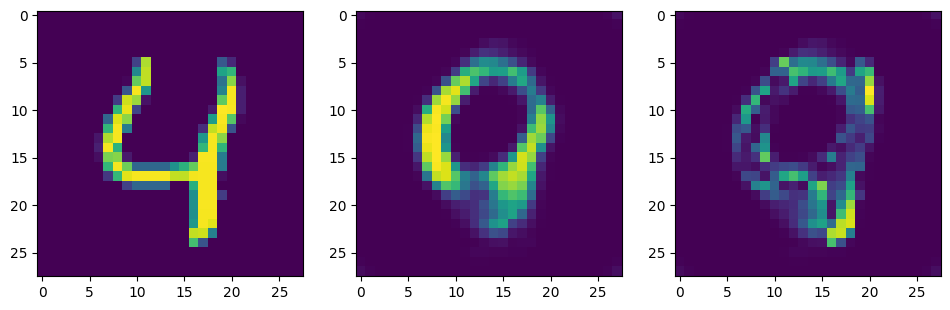

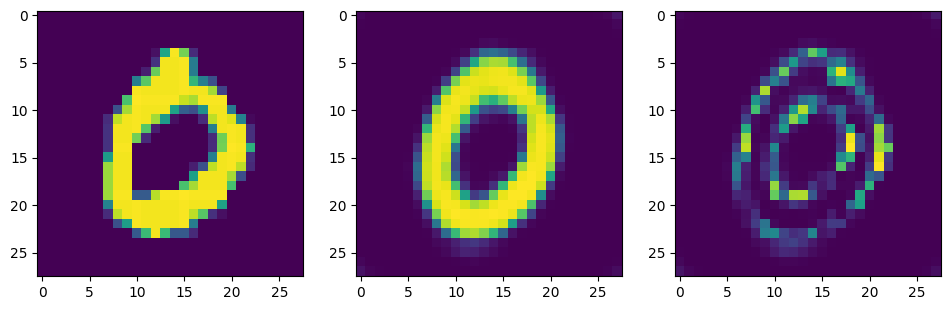

In [67]:
show_item_reconstructio(4)
show_item_reconstructio(3)

EMNIST VIS:   0%|          | 0/40 [00:00<?, ?it/s]

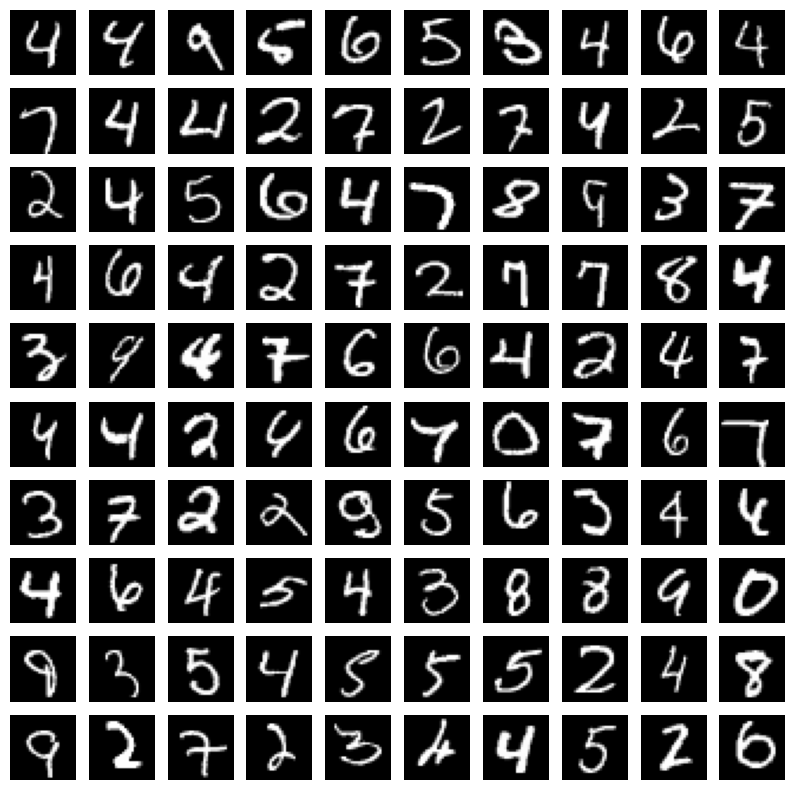

In [68]:
threshold = optimal_threshold
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > threshold):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break